In [11]:
#export
from exp.nb_04 import *
from functools import partial 

## Initial 

In [2]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [3]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)



In [4]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [5]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])


In [6]:
run.fit(3, learn)

train: [0.6357263671875, tensor(0.7980)]
valid: [0.299017431640625, tensor(0.9055)]
train: [0.22729534505208332, tensor(0.9319)]
valid: [0.18255120849609374, tensor(0.9419)]
train: [0.17752950846354168, tensor(0.9475)]
valid: [0.19984544677734375, tensor(0.9391)]


In [7]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)



## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

[Jump_to lesson 9 video](https://course19.fast.ai/videos/?lesson=9&t=7202)


In [8]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()


In [ ]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [12]:
f = sched_lin(1,2)
f(0.3)

1.3

In [13]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

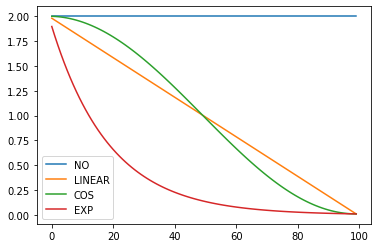

In [14]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [15]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        if idx == 2: idx = 1
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [16]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

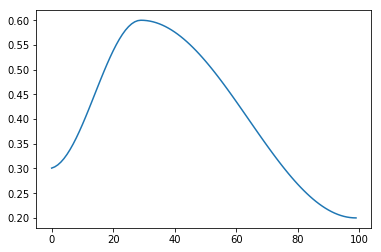

In [ ]:
plt.plot(a, [sched(o) for o in p])

In [18]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [ ]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [ ]:
run.fit(3, learn)

train: [0.788337578125, tensor(0.7860)]
valid: [0.3378462158203125, tensor(0.8999)]
train: [0.29788216796875, tensor(0.9127)]
valid: [0.2410066162109375, tensor(0.9319)]
train: [0.23813974609375, tensor(0.9312)]
valid: [0.2132032958984375, tensor(0.9400)]


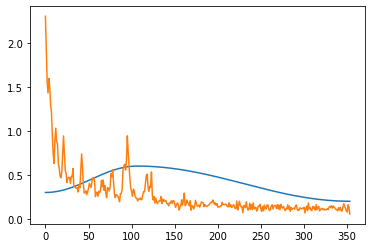

In [23]:
run.recorder.plot_lr()

run.recorder.plot_loss()

In [22]:
!python notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to exp/nb_05.py
